<a href="https://colab.research.google.com/github/Fikaaw/amazing-feat-eng/blob/main/absa_best_team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## initialization

In [ ]:
import numpy as np
import pandas as pd
import re
import string
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import plotly.express as px
import plotly.graph_objects as go
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import logging
import torch.optim as optim
import nltk

from transformers import AutoTokenizer, AutoModel, AutoConfig

tokenizer = AutoTokenizer.from_pretrained("crypter70/IndoBERT-Sentiment-Analysis")
config = AutoConfig.from_pretrained("crypter70/IndoBERT-Sentiment-Analysis")
model = AutoModel.from_pretrained("crypter70/IndoBERT-Sentiment-Analysis", config=config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

## data loader

In [ ]:
text = pd.read_csv('https://raw.githubusercontent.com/najwhoas/absa-project/main/dataset-final.csv')

In [ ]:
text_data = text['clean_review'].values
output_sentiment = text[['y_rasa', 'y_pelayanan', 'y_tempat', 'y_harga']].values
output_confidence = np.abs(text[['c_rasa', 'c_pelayanan', 'c_tempat', 'c_harga']].values)

# Split the data
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
    text_data, output_sentiment, output_confidence, test_size=0.2, random_state=42)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, sentiment_labels, confidence_labels, tokenizer, max_length):
        self.texts = texts
        self.sentiment_labels = sentiment_labels
        self.confidence_labels = confidence_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        sentiment_label = self.sentiment_labels[idx]
        confidence_label = self.confidence_labels[idx]

        inputs = self.tokenizer(text,
                                add_special_tokens=True,
                                max_length=self.max_length,
                                padding='max_length',  # Updated argument
                                return_token_type_ids=False,
                                return_attention_mask=True,
                                truncation=True,
                                return_tensors='pt')

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'sentiment_labels': torch.tensor(sentiment_label, dtype=torch.float32),
            'confidence_labels': torch.tensor(confidence_label, dtype=torch.float32)
        }

In [ ]:
train_dataset = CustomDataset(X_train, y_train, c_train, tokenizer, 64)
test_dataset = CustomDataset(X_test, y_test, c_test, tokenizer, 64)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## model

In [ ]:
class BertForMultiTaskSequenceClassification(nn.Module):
    def __init__(self, model):
        super(BertForMultiTaskSequenceClassification, self).__init__()
        self.bert = model
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state.mean(dim=1)
        pooled_output = self.dropout(pooled_output)
        return pooled_output

embedding_model = BertForMultiTaskSequenceClassification(model)

In [ ]:
class Attention(nn.Module):
    def __init__(self, attention_size):
        super(Attention, self).__init__()
        self.attention_weights = nn.Linear(attention_size, 1, bias=False)

    def forward(self, lstm_output):
        attention_scores = self.attention_weights(lstm_output).squeeze(-1)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_sum = torch.sum(lstm_output * attention_weights.unsqueeze(-1), dim=1)
        return weighted_sum, attention_weights

In [ ]:
class ABSA_LSTM_CNN(nn.Module):
    def __init__(self, embedding_model, input_size, hidden_size, num_layers, num_classes_sentiment, num_classes_confidence):
        super(ABSA_LSTM_CNN, self).__init__()
        self.embedding_model = embedding_model
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=256, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, dropout=0.2, bidirectional=True)
        self.attention = Attention(hidden_size * 2)

        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 32)

        self.fc_sentiment = nn.Linear(32, num_classes_sentiment)
        self.fc_confidence = nn.Linear(32, num_classes_confidence)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        embeddings = self.embedding_model(input_ids, attention_mask)
        embeddings = embeddings.unsqueeze(1).repeat(1, input_ids.size(1), 1)

        x = embeddings.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(input_ids.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(input_ids.device)
        out, _ = self.lstm(x, (h0, c0))

        attn_output, _ = self.attention(out)

        out = self.fc1(attn_output)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu(out)

        sentiment = self.fc_sentiment(out)
        sentiment = self.tanh(sentiment)

        confidence = self.fc_confidence(out)
        confidence = self.sigmoid(confidence)

        return sentiment, confidence

In [ ]:
input_size = 768
hidden_size = 256
num_layers = 1
num_classes_sentiment = 4
num_classes_confidence = 4

absa_model_v4 = ABSA_LSTM_CNN(embedding_model, input_size, hidden_size, num_layers, num_classes_sentiment, num_classes_confidence)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
print(absa_model_v4)

ABSA_LSTM_CNN(
  (embedding_model): BertForMultiTaskSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(50000, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=

## train

In [ ]:
def calculate_accuracy(predictions, targets):
    if len(predictions) != len(targets):
        raise ValueError("Length of predictions and targets must be the same")

    num_correct = sum(p == t for p, t in zip(predictions, targets))
    accuracy = num_correct / len(predictions)

    return accuracy

In [ ]:
def calculate_metrics(predictions, targets, average='macro'):
    precision = precision_score(targets, predictions, average=average)
    recall = recall_score(targets, predictions, average=average)
    f1 = f1_score(targets, predictions, average=average)
    return precision, recall, f1

In [ ]:
def evaluate_model(model, data_loader, criterion_sentiment, criterion_confidence):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_sentiment_accuracy = 0.0
    total_confidence_accuracy = 0.0
    total_sentiment_precision = 0.0
    total_sentiment_recall = 0.0
    total_sentiment_f1 = 0.0
    total_confidence_precision = 0.0
    total_confidence_recall = 0.0
    total_confidence_f1 = 0.0
    total_batches = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)  # Memindahkan tensor ke perangkat CUDA jika tersedia
            attention_mask = batch['attention_mask'].to(device)
            sentiment_labels = batch['sentiment_labels'].to(device)
            confidence_labels = batch['confidence_labels'].to(device)

            sentiment_output, confidence_output = model(input_ids, attention_mask)

            loss_sentiment = criterion_sentiment(sentiment_output, sentiment_labels)
            loss_confidence = criterion_confidence(confidence_output, confidence_labels)
            total_loss_batch = loss_sentiment + loss_confidence

            # Calculate predictions
            sentiment_preds = torch.round(sentiment_output).cpu().numpy()  # Pindahkan ke CPU sebelum konversi ke numpy
            confidence_preds = torch.round(confidence_output).cpu().numpy()
            output_sentiment_batch_np = sentiment_labels.cpu().numpy()
            output_confidence_batch_np = confidence_labels.cpu().numpy()

            # Calculate accuracy
            accuracy_sentiment = calculate_accuracy(sentiment_preds.flatten(), output_sentiment_batch_np.flatten())
            accuracy_confidence = calculate_accuracy(confidence_preds.flatten(), output_confidence_batch_np.flatten())

            # Calculate precision, recall, and f1 score
            precision_sentiment, recall_sentiment, f1_sentiment = calculate_metrics(sentiment_preds.flatten(), output_sentiment_batch_np.flatten())
            precision_confidence, recall_confidence, f1_confidence = calculate_metrics(confidence_preds.flatten(), output_confidence_batch_np.flatten())

            # Accumulate metrics
            total_loss += total_loss_batch.item()
            total_sentiment_accuracy += accuracy_sentiment
            total_confidence_accuracy += accuracy_confidence
            total_sentiment_precision += precision_sentiment
            total_sentiment_recall += recall_sentiment
            total_sentiment_f1 += f1_sentiment
            total_confidence_precision += precision_confidence
            total_confidence_recall += recall_confidence
            total_confidence_f1 += f1_confidence
            total_batches += 1

    avg_loss = total_loss / total_batches
    avg_sentiment_metrics = {
        "accuracy": total_sentiment_accuracy / total_batches,
        "precision": total_sentiment_precision / total_batches,
        "recall": total_sentiment_recall / total_batches,
        "f1": total_sentiment_f1 / total_batches
    }
    avg_confidence_metrics = {
        "accuracy": total_confidence_accuracy / total_batches,
        "precision": total_confidence_precision / total_batches,
        "recall": total_confidence_recall / total_batches,
        "f1": total_confidence_f1 / total_batches
    }

    return avg_loss, avg_sentiment_metrics, avg_confidence_metrics


In [ ]:
# Training setup
device = torch.device('cuda')
absa_model_v4.to(device)

criterion_sentiment = nn.MSELoss()
criterion_confidence = nn.MSELoss()
optimizer = optim.Adam(absa_model_v4.parameters(), lr=2e-5)

epochs = 100

train_losses = []
train_sentiment_accuracies = []
train_confidence_accuracies = []
test_losses = []
test_sentiment_accuracies = []
test_confidence_accuracies = []

def train_and_evaluate(train_loader, test_loader, model, optimizer, criterion_sentiment, criterion_confidence, num_epochs):
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_sentiment_accuracy = 0.0
        total_confidence_accuracy = 0.0
        total_batches = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiment_labels = batch['sentiment_labels'].to(device)
            confidence_labels = batch['confidence_labels'].float().to(device)

            optimizer.zero_grad()
            sentiment_output, confidence_output = model(input_ids, attention_mask)

            loss_sentiment = criterion_sentiment(sentiment_output, sentiment_labels)
            loss_confidence = criterion_confidence(confidence_output, confidence_labels)
            loss = loss_sentiment + loss_confidence

            # Calculate accuracy
            sentiment_preds = torch.round(sentiment_output.detach())
            confidence_preds = torch.round(confidence_output.detach())

            # Pindahkan ke CPU sebelum konversi ke numpy
            sentiment_preds_np = sentiment_preds.cpu().numpy()
            confidence_preds_np = confidence_preds.cpu().numpy()
            sentiment_labels_np = sentiment_labels.cpu().numpy()
            confidence_labels_np = confidence_labels.cpu().numpy()

            accuracy_sentiment = calculate_accuracy(sentiment_preds_np.flatten(), sentiment_labels_np.flatten())
            accuracy_confidence = calculate_accuracy(confidence_preds_np.flatten(), confidence_labels_np.flatten())

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            total_sentiment_accuracy += accuracy_sentiment
            total_confidence_accuracy += accuracy_confidence
            total_batches += 1

        avg_loss = train_loss / total_batches
        avg_sentiment_accuracy = total_sentiment_accuracy / total_batches
        avg_confidence_accuracy = total_confidence_accuracy / total_batches

        # Store metrics for plotting
        train_losses.append(avg_loss)
        train_sentiment_accuracies.append(avg_sentiment_accuracy)
        train_confidence_accuracies.append(avg_confidence_accuracy)

        # Print training progress
        print(f'Epoch [{epoch+1}/{epochs}]:\n '
              f'Loss: {avg_loss:.8f}, '
              f'Sentiment Accuracy: {avg_sentiment_accuracy:.8f}, '
              f'Confidence Accuracy: {avg_confidence_accuracy:.8f}')

        # Evaluate the model on the test set
        test_loss, test_sentiment_accuracy, test_confidence_accuracy = evaluate_model(model, test_loader, criterion_sentiment, criterion_confidence)

        # Store test metrics
        test_losses.append(test_loss)
        test_sentiment_accuracies.append(test_sentiment_accuracy["accuracy"])
        test_confidence_accuracies.append(test_confidence_accuracy["accuracy"])

        # Print evaluation metrics
        print(f'Test Loss: {test_loss:.8f},'
              f'Test Sentiment Accuracy: {test_sentiment_accuracy["accuracy"]:.8f}, '
              f'Test Confidence Accuracy: {test_confidence_accuracy["accuracy"]:.8f}')


# Run the training and evaluation
train_and_evaluate(train_dataloader, test_dataloader, absa_model_v4, optimizer, criterion_sentiment, criterion_confidence, epochs)

Epoch [1/100]:
 Loss: 0.58329722, Sentiment Accuracy: 0.64090774, Confidence Accuracy: 0.48489583


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Test Loss: 0.55227423,Test Sentiment Accuracy: 0.64438657, Test Confidence Accuracy: 0.47945602
Epoch [2/100]:
 Loss: 0.54145240, Sentiment Accuracy: 0.64102679, Confidence Accuracy: 0.49354167


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Test Loss: 0.51950563,Test Sentiment Accuracy: 0.64438657, Test Confidence Accuracy: 0.48697917
Epoch [3/100]:
 Loss: 0.51536628, Sentiment Accuracy: 0.64098214, Confidence Accuracy: 0.50337798


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Test Loss: 0.49721816,Test Sentiment Accuracy: 0.64438657, Test Confidence Accuracy: 0.55092593
Epoch [4/100]:
 Loss: 0.48426904, Sentiment Accuracy: 0.64629464, Confidence Accuracy: 0.55431548


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Test Loss: 0.46535609,Test Sentiment Accuracy: 0.66319444, Test Confidence Accuracy: 0.61111111
Epoch [5/100]:
 Loss: 0.44859346, Sentiment Accuracy: 0.68494048, Confidence Accuracy: 0.60544643
Test Loss: 0.43464136,Test Sentiment Accuracy: 0.74103009, Test Confidence Accuracy: 0.66290509
Epoch [6/100]:
 Loss: 0.41097713, Sentiment Accuracy: 0.74766369, Confidence Accuracy: 0.65502976
Test Loss: 0.40688010,Test Sentiment Accuracy: 0.78009259, Test Confidence Accuracy: 0.67766204
Epoch [7/100]:
 Loss: 0.38033108, Sentiment Accuracy: 0.79586310, Confidence Accuracy: 0.67845238
Test Loss: 0.38270705,Test Sentiment Accuracy: 0.80902778, Test Confidence Accuracy: 0.73234954
Epoch [8/100]:
 Loss: 0.34900641, Sentiment Accuracy: 0.83873512, Confidence Accuracy: 0.71226190
Test Loss: 0.35544214,Test Sentiment Accuracy: 0.84027778, Test Confidence Accuracy: 0.71903935
Epoch [9/100]:
 Loss: 0.31913189, Sentiment Accuracy: 0.87160714, Confidence Accuracy: 0.71638393
Test Loss: 0.33517878,Test Sen

## predict

In [ ]:
def predict_reviews(review_data, max_sequence_length, model, tokenizer):
    model.eval()  # Set model to evaluation mode

    for review_text in review_data:
        # Tokenize the review text
        encoded_input = tokenizer(review_text, padding='max_length', truncation=True, max_length=max_sequence_length, return_tensors='pt')

        input_ids = encoded_input['input_ids'].to(device)
        attention_mask = encoded_input['attention_mask'].to(device)

        with torch.no_grad():
            sentiment_pred, confidence_pred = model(input_ids, attention_mask)

        # Post-process prediction
        sentiment_pred = sentiment_pred.cpu().numpy()
        confidence_pred = confidence_pred.cpu().numpy()

        sentiment_pred = np.round(sentiment_pred).astype(int)
        confidence_pred = np.round(confidence_pred).astype(int)

        # Print prediction
        print("Review:", review_text)
        print("[Rasa, Pelayanan, Tempat, Harga]")
        print("Sentiment prediction:", sentiment_pred[0])
        print("Confidence prediction:", confidence_pred[0])
        print("")


review_data = [
    "hahahaha apaan rasa makanan kaya gini mana karyawan jutek banget",
    "enak sih enak tapi cuy ini tuh kemahalan banget harganya. kapok juga dompet gue",
    "rasanya lumayan",
    'makanannya standar si biasa aja',
    'tempatnya cukup nyaman, harganya juga murah untuk porsi yang besar',
    'rasanya biasa aja padahal harganya udah tergolong mahal',
    'makanannya standar si, tapi harganya murah banget, pelayananny juga memuaskan'
]

max_sequence_length = 64

# Assuming custom_model and tokenizer are already defined and loaded as per your provided code
predict_reviews(review_data, max_sequence_length, absa_model_v4, tokenizer)


Review: hahahaha apaan rasa makanan kaya gini mana karyawan jutek banget
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [-1 -1  0  0]
Confidence prediction: [1 1 0 0]

Review: enak sih enak tapi cuy ini tuh kemahalan banget harganya. kapok juga dompet gue
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [ 1  0  0 -1]
Confidence prediction: [1 0 0 1]

Review: rasanya lumayan
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [0 0 0 0]
Confidence prediction: [1 0 0 0]

Review: makanannya standar si biasa aja
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [0 0 0 0]
Confidence prediction: [1 0 0 0]

Review: tempatnya cukup nyaman, harganya juga murah untuk porsi yang besar
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [0 0 0 1]
Confidence prediction: [0 0 1 1]

Review: rasanya biasa aja padahal harganya udah tergolong mahal
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [ 0  0  0 -1]
Confidence prediction: [1 0 0 1]

Review: makanannya standar si,

## metrics

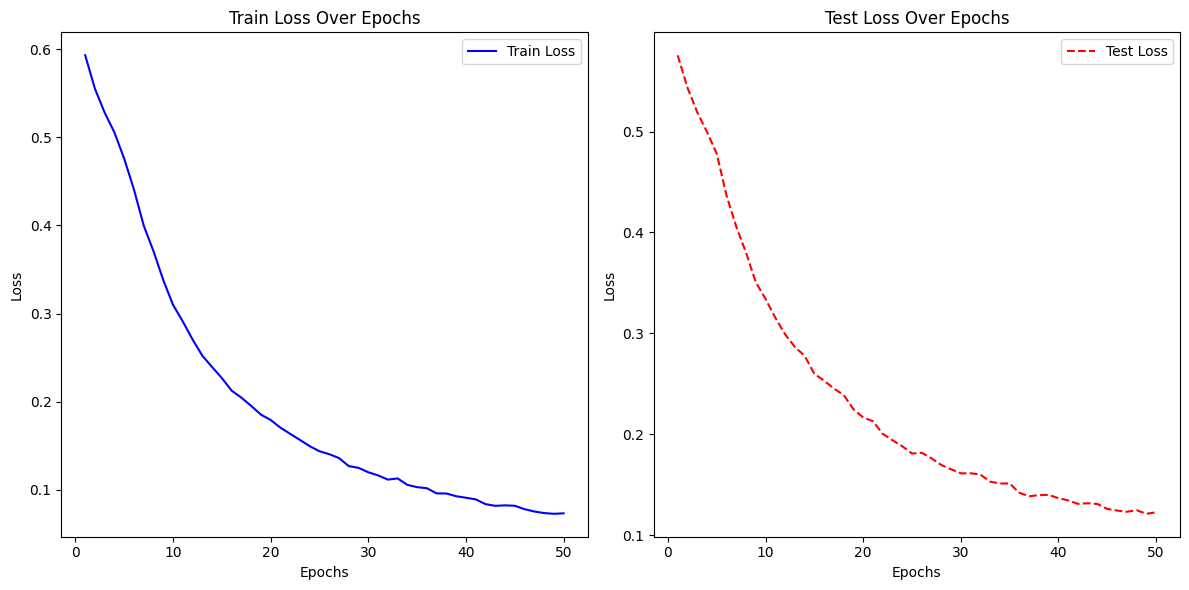

In [ ]:
epochs_range = range(1, epochs + 1)

# Plot train loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()

# Plot test loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_losses, label='Test Loss', color='red',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

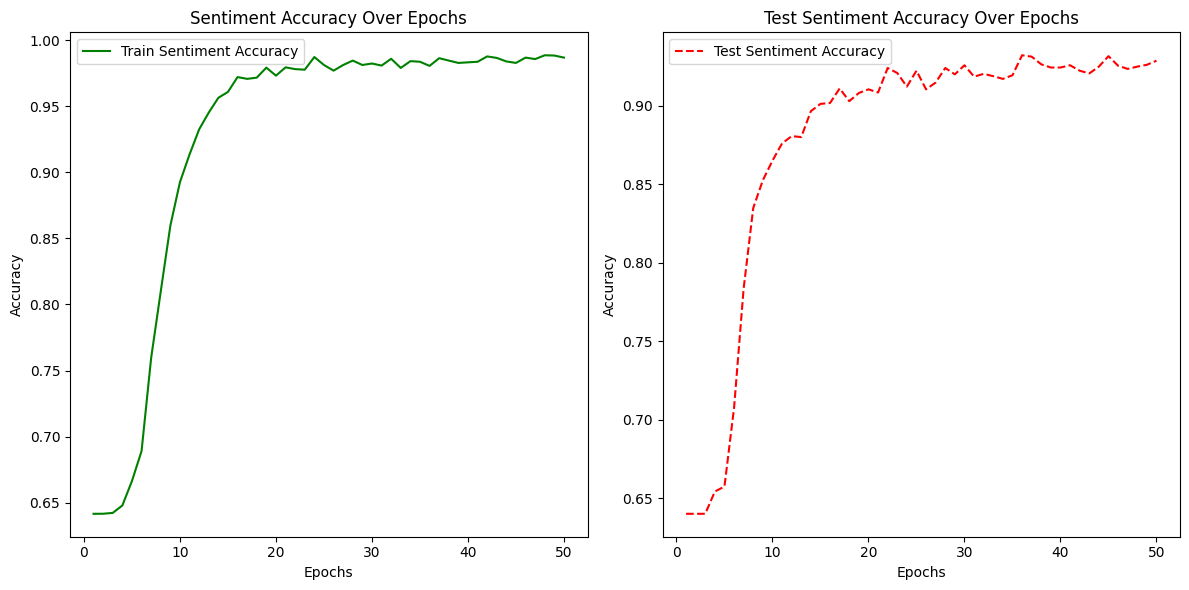

In [ ]:
# Plot train and test sentiment accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_sentiment_accuracies,color='green', label='Train Sentiment Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Sentiment Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_sentiment_accuracies, label='Test Sentiment Accuracy',color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Sentiment Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

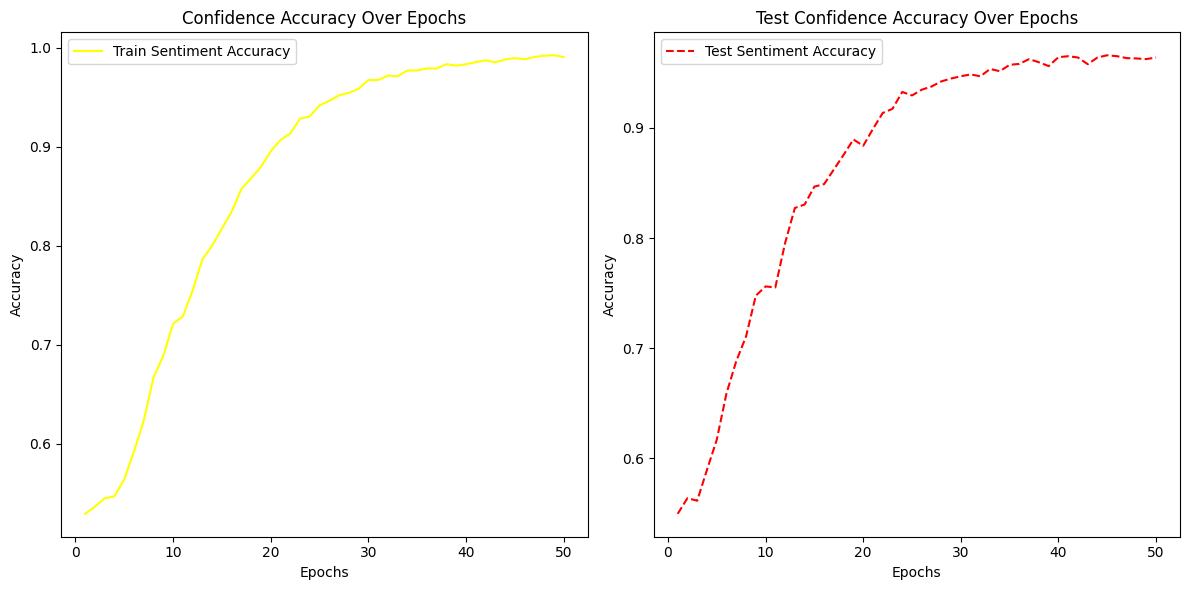

In [ ]:
# Plot train and test confidence accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_confidence_accuracies,color='yellow', label='Train Sentiment Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Confidence Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_confidence_accuracies, color='red', label='Test Sentiment Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Confidence Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
sentiment_metrics_values = [test_sentiment_accuracy["accuracy"], test_sentiment_accuracy["precision"], test_sentiment_accuracy["recall"], test_sentiment_accuracy["f1"]]
confidence_metrics_values = [test_confidence_accuracy["accuracy"], test_confidence_accuracy["precision"], test_confidence_accuracy["recall"], test_confidence_accuracy["f1"]]

# Palet warna pastel
sentiment_color = '#FF6347'
confidence_color = '#32CD32'

# Plot test metrics
plt.figure(figsize=(12, 6))

# Plot test sentiment metrics
plt.subplot(1, 2, 1)
plt.barh(test_metrics_names, sentiment_metrics_values, color=sentiment_color)
plt.xlim(0, 1)
plt.title('Test Sentiment Metrics')
for i, v in enumerate(sentiment_metrics_values):
    plt.text(v, i, f'{v:.2f}', ha='left', va='center')

# Plot test confidence metrics
plt.subplot(1, 2, 2)
plt.barh(test_metrics_names, confidence_metrics_values, color=confidence_color)
plt.xlim(0, 1)
plt.title('Test Confidence Metrics')
for i, v in enumerate(confidence_metrics_values):
    plt.text(v, i, f'{v:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()

NameError: name 'test_sentiment_accuracy' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(metrics, title):
    metrics_names = list(metrics.keys())
    metrics_values = list(metrics.values())

    plt.figure(figsize=(10, 6))
    plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'orange'])
    plt.title(title)
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.ylim(0, 1)  # Menetapkan batas y antara 0 dan 1 untuk persentase
    plt.show()

# Ambil hasil evaluasi dari model
test_sentiment_accuracy = test_sentiment_accuracy_list[-1]
test_confidence_accuracy = test_confidence_accuracy_list[-1]

# Plot untuk metrik sentimen
plot_metrics(test_sentiment_accuracy, 'Test Sentiment Metrics')

# Plot untuk metrik kepercayaan
plot_metrics(test_confidence_accuracy, 'Test Confidence Metrics')


## save

In [ ]:
# path = "model-absa.pth"

# # Simpan model
# torch.save(absa_model_v4, path)